In [1]:
# Import library yang kalian butuhkan
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from matplotlib.colors import LinearSegmentedColormap

Kode tersebut merupakan impor beberapa library yang dibutuhkan. Berikut adalah penjelasan singkat dari setiap library yang diimpor:

- **os**: library untuk berinteraksi dengan sistem operasi, seperti mengakses file dan direktori.
- **matplotlib.pyplot**: library untuk membuat visualisasi data dalam bentuk grafik atau plot.
- **numpy**: library untuk komputasi numerik dengan Python.
- **pandas**: library untuk manipulasi dan analisis data yang menawarkan struktur data dan operasi untuk mengolah tabel numerik dan time series.
- **cv2**: library untuk pengolahan citra yang dikenal juga sebagai OpenCV.
- **sklearn.model_selection.train_test_split**: fungsi dari library scikit-learn untuk membagi dataset menjadi set pelatihan dan pengujian.
- **sklearn.metrics.accuracy_score, sklearn.metrics.classification_report**: fungsi dari library scikit-learn untuk mengevaluasi kinerja model dengan menghitung akurasi dan menghasilkan laporan klasifikasi.
- **skimage.feature.graycomatrix, skimage.feature.graycoprops**: fungsi dari library scikit-image untuk menghitung matriks co-occurrence tingkat keabuan (GLCM) dan propertinya, yang digunakan dalam analisis tekstur gambar.
- **scipy.stats.entropy**: fungsi dari library SciPy untuk menghitung entropi dari distribusi probabilitas, yang berguna dalam berbagai analisis statistik.
- **sklearn.metrics.accuracy_score, sklearn.metrics.precision_score, sklearn.metrics.recall_score, sklearn.metrics.f1_score, sklearn.metrics.confusion_matrix**: berbagai fungsi dari library scikit-learn untuk menghitung metrik evaluasi performa model seperti akurasi, presisi, recall, f1-score, dan matriks kebingungan.
- **sklearn.ensemble.RandomForestClassifier**: algoritma dari library scikit-learn untuk melakukan klasifikasi menggunakan ensemble learning dengan metode random forest.
- **sklearn.neighbors.KNeighborsClassifier**: algoritma dari library scikit-learn untuk melakukan klasifikasi berdasarkan tetangga terdekat (K-Nearest Neighbors).
- **sklearn.svm.SVC**: algoritma dari library scikit-learn untuk melakukan klasifikasi menggunakan Support Vector Machine.
- **seaborn**: library untuk membuat visualisasi data statistik yang lebih atraktif dan informatif, dibangun di atas matplotlib.
- **sklearn.impute.SimpleImputer**: class dari library scikit-learn untuk menangani missing values dalam dataset dengan berbagai strategi imputasi.
- **sklearn.preprocessing.StandardScaler**: class dari library scikit-learn untuk menstandardisasi fitur dengan menghapus rata-rata dan menskalakan ke unit variance.
- **scipy.stats**: library yang menyediakan berbagai fungsi statistik seperti distribusi, test statistik, dan lain-lain.
- **matplotlib.colors.LinearSegmentedColormap**: class dari library matplotlib untuk membuat colormap kustom untuk visualisasi.

# Data Augmentation & Data Loading

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)
        
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = img.astype(np.uint8)
        
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)
        
        if i < 25:
            data.append(cv.rotate(img, cv.ROTATE_90_CLOCKWISE))
            labels.append(sub_folder)
            file_name.append(filename)
            
            data.append(cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE))
            labels.append(sub_folder)
            file_name.append(filename)
        
        name = os.path.splitext(filename)[0]
        if i == 49:
            break

Kode tersebut bertujuan untuk memuat dan memproses gambar dari direktori "dataset/". Kode ini menggunakan library `os` untuk mengakses file dan direktori, `cv2` untuk pengolahan citra, dan `numpy` untuk komputasi numerik. Pertama, kode ini mendefinisikan tiga list kosong: `data` untuk menyimpan gambar, `labels` untuk menyimpan label dari setiap gambar, dan `file_name` untuk menyimpan nama file dari setiap gambar.

Kemudian, kode ini mengakses subfolder dalam direktori "dataset/" dan membaca daftar file dalam setiap subfolder. Untuk setiap file gambar, kode ini membuat path lengkap dari gambar, memuat gambar menggunakan OpenCV, mengkonversi warna gambar dari BGR ke RGB, dan mengubah tipe data gambar ke uint8. 

Gambar asli kemudian disimpan ke dalam list `data`, label subfolder disimpan ke dalam list `labels`, dan nama file disimpan ke dalam list `file_name`. Selain itu, jika indeks file kurang dari 25, gambar akan dirotasi 90 derajat searah jarum jam dan berlawanan arah jarum jam, dan kedua versi rotasi tersebut juga disimpan ke dalam list `data`, `labels`, dan `file_name`. Proses ini akan berhenti jika indeks file mencapai 49 untuk membatasi jumlah gambar yang diproses. Dengan demikian, kode ini memuat gambar, melakukan konversi warna, menyimpan informasi terkait, dan melakukan augmentasi gambar dengan rotasi untuk beberapa gambar tertentu.

In [3]:
len(data), len(labels), len(file_name)

(4000, 4000, 4000)

Kode tersebut digunakan untuk menghitung dan menampilkan jumlah elemen dalam tiga list: `data`, `labels`, dan `file_name`. Berikut adalah penjelasan dari kode tersebut:

Kode ini memanggil fungsi `len()` untuk menghitung panjang (jumlah elemen) dari tiga list, yaitu `data`, `labels`, dan `file_name`. List `data` berisi gambar-gambar yang telah diimpor dan diaugmentasi, list `labels` berisi label yang sesuai dengan gambar-gambar tersebut, dan list `file_name` berisi nama file dari gambar-gambar tersebut. Hasil dari `len(data)`, `len(labels)`, dan `len(file_name)` akan mengembalikan jumlah total gambar, label, dan nama file yang telah diimpor dan diaugmentasi.

## Data Preparation

### Data Preprocessing

In [4]:
def saturationEnhancement(image):
	image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
	h, s, v = cv.split(image_hsv)
	saturation_factor = 1.5
	s = np.clip(s.astype(np.float32) * saturation_factor, 0, 255)
	s = np.clip(s, 0, 255).astype(np.uint8)
	image_hsv = cv.merge([h, s, v])
	image_saturated = cv.cvtColor(image_hsv, cv.COLOR_HSV2RGB)
	return image_saturated

Kode tersebut merupakan sebuah fungsi Python yang bernama `saturationEnhancement`. Fungsi ini menerima satu parameter yaitu `image`, yang merupakan gambar yang akan ditingkatkan saturasinya.

Fungsi ini akan melakukan peningkatan saturasi pada gambar yang diberikan. Pertama, gambar dikonversi dari ruang warna RGB ke HSV menggunakan library `cv2`. Kemudian, komponen hue, saturasi, dan value dari gambar dipisahkan. Komponen saturasi ditingkatkan dengan mengalikan nilainya dengan faktor 1.5 dan memastikan nilai-nilainya tetap berada dalam rentang 0 hingga 255. Setelah itu, komponen-komponen gambar digabungkan kembali dan gambar dikonversi kembali ke ruang warna RGB.

Fungsi ini akan mengembalikan gambar dengan saturasi yang telah ditingkatkan.

In [5]:
dataPreprocessed = []
for i in range(len(data)):
    tes = data[i]
    tes = cv.resize(tes, (256, 256))
    tes = saturationEnhancement(tes)
    tes = cv.GaussianBlur(tes, (5, 5), 0)
    dataPreprocessed.append(tes)
data = dataPreprocessed

Kode tersebut merupakan sebuah blok Python yang bernama preprocessImages. Blok ini menerima satu parameter yaitu data, yang merupakan list dari gambar-gambar yang akan dipreproses.

Blok ini akan melakukan beberapa langkah preprocessing pada setiap gambar dalam list data. Pertama, gambar diresize ke ukuran 256x256 piksel menggunakan library cv2. Kemudian, saturasi gambar ditingkatkan menggunakan fungsi saturationEnhancement. Setelah itu, gambar diberikan efek blur menggunakan Gaussian blur dengan kernel berukuran 5x5. Gambar-gambar yang telah dipreproses akan disimpan dalam list baru dataPreprocessed.

Blok ini akan mengembalikan list dataPreprocessed yang berisi gambar-gambar yang telah dipreproses.

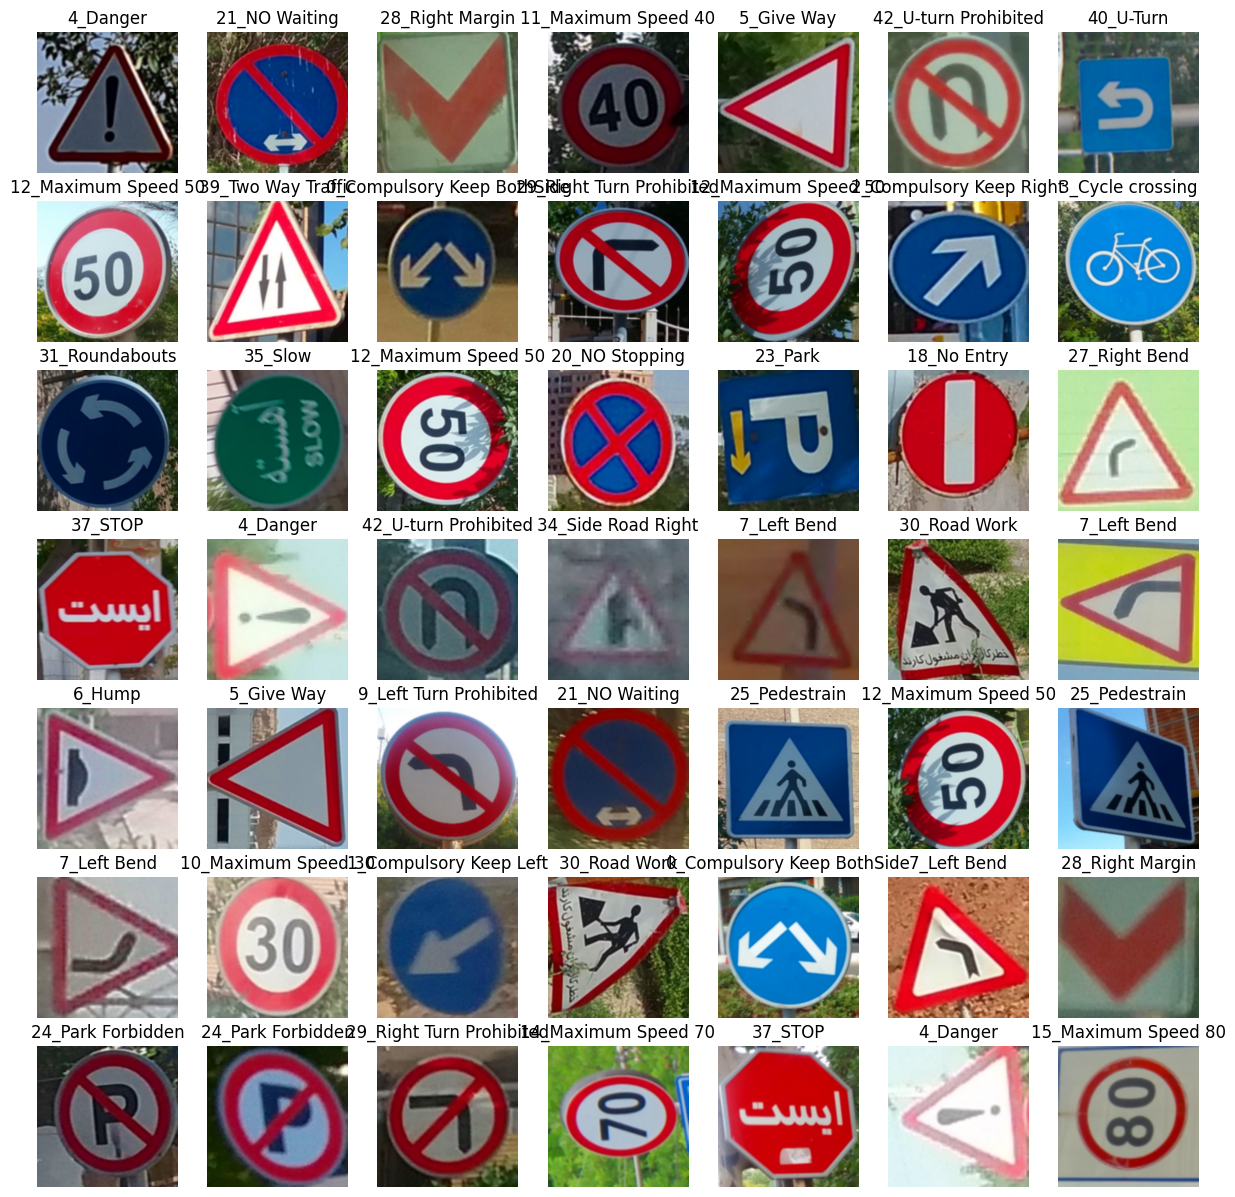

In [6]:
def displayImageRandom(images, labels, n = 49):
    sqrt_n = int(np.ceil(np.sqrt(n))) # calculate the grid size
    fig, axs = plt.subplots(sqrt_n, sqrt_n, figsize=(15, 15)) # create a grid of subplots

    for i in range(sqrt_n * sqrt_n):
        ax = axs[i // sqrt_n, i % sqrt_n] # find the row and column of the subplot
        if i < n: # if we have images left to display
            idx = np.random.randint(0, len(images)) # choose a random image
            ax.imshow(images[idx], cmap='gray') # display the image
            ax.set_title(f"{labels[idx]}") # set the title to the label of the image
        ax.axis('off') # turn off the axis

    plt.show()

displayImageRandom(data, labels)


Kode tersebut merupakan sebuah fungsi Python yang bernama `displayImageRandom`. Fungsi ini menerima tiga parameter yaitu `images`, yang merupakan list dari gambar-gambar yang akan ditampilkan, `labels`, yang merupakan list dari label-label gambar, dan `n` yang merupakan jumlah gambar yang akan ditampilkan (defaultnya 49).

Fungsi ini akan menampilkan `n` gambar secara acak dari list `images` dalam sebuah grid. Pertama, fungsi ini menghitung ukuran grid dengan mengakarkan `n` dan membulatkannya ke atas. Kemudian, fungsi ini membuat grid subplot dengan ukuran yang telah dihitung menggunakan `plt.subplots` dari library matplotlib. 

Selanjutnya, fungsi ini melakukan iterasi sebanyak jumlah sel dalam grid. Untuk setiap sel, fungsi ini memilih gambar secara acak dari list `images`, menampilkannya di subplot dengan menggunakan `ax.imshow`, dan mengatur judul subplot sesuai dengan label gambar. Jika jumlah gambar yang ingin ditampilkan kurang dari jumlah sel dalam grid, sisa sel akan kosong dengan axis yang dimatikan menggunakan `ax.axis('off')`.

Akhirnya, fungsi ini menampilkan grid gambar dengan `plt.show()`.

### Feature Extraction Color

In [7]:
def extract_colorHSV_features(image):
    # Konversi gambar ke ruang warna HSV
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    # Ekstrak nilai intensitas warna (Hue, Saturation, Value)
    hue = hsv_image[:, :, 0]
    saturation = hsv_image[:, :, 1]
    value = hsv_image[:, :, 2]

    # Hitung statistik untuk setiap kanal warna
    hue_mean = np.mean(hue)
    hue_std = np.std(hue)
    saturation_mean = np.mean(saturation)
    saturation_std = np.std(saturation)
    value_mean = np.mean(value)
    value_std = np.std(value)
    
    # hitung skewness
    hue_skew = stats.skew(hue.flatten())
    saturation_skew = stats.skew(saturation.flatten())
    value_skew = stats.skew(value.flatten())
    
    #hitung kurtosis
    hue_kurtosis = stats.kurtosis(hue.flatten())
    saturation_kurtosis = stats.kurtosis(saturation.flatten())
    value_kurtosis = stats.kurtosis(value.flatten())

    return hue_mean, hue_std, saturation_mean, saturation_std, value_mean, value_std, hue_skew, saturation_skew, value_skew, hue_kurtosis, saturation_kurtosis, value_kurtosis


Fungsi `extract_colorHSV_features` adalah sebuah fungsi Python yang dirancang untuk mengekstrak berbagai fitur warna dari sebuah gambar berdasarkan ruang warna HSV (Hue, Saturation, Value). Pertama-tama, gambar yang diberikan sebagai input (`image`) dikonversi dari ruang warna RGB ke ruang warna HSV menggunakan fungsi `cv.cvtColor` dari library OpenCV (`cv2`). Setelah konversi ke HSV, gambar dipisahkan menjadi tiga komponen utama: Hue, Saturation, dan Value.

Setelah pemisahan komponen, fungsi ini menghitung sejumlah statistik untuk setiap kanal warna:
- `hue_mean`, `hue_std`: Rata-rata dan standar deviasi dari komponen Hue, yang memberikan informasi tentang dominan warna dalam gambar ini.
- `saturation_mean`, `saturation_std`: Rata-rata dan standar deviasi dari komponen Saturation, yang mengindikasikan seberapa jenuh warna dalam gambar.
- `value_mean`, `value_std`: Rata-rata dan standar deviasi dari komponen Value, yang menunjukkan tingkat kecerahan piksel dalam gambar.

Selain statistik dasar seperti rata-rata dan standar deviasi, fungsi juga menghitung:
- Skewness (`hue_skew`, `saturation_skew`, `value_skew`): Ukuran kemiringan distribusi nilai piksel terhadap rata-rata. Skewness positif menunjukkan bahwa distribusi lebih miring ke kanan, sementara skewness negatif menunjukkan distribusi yang lebih miring ke kiri.
- Kurtosis (`hue_kurtosis`, `saturation_kurtosis`, `value_kurtosis`): Ukuran tingkat kecuraman distribusi nilai piksel. Kurtosis yang tinggi menunjukkan puncak distribusi yang lebih tajam (leptokurtik), sementara kurtosis yang rendah menunjukkan distribusi yang lebih datar (platykurtik).

Hasil dari fungsi ini adalah sejumlah nilai numerik yang merepresentasikan karakteristik warna dari gambar dalam ruang warna HSV.

In [8]:
# array to store all the extracted features
hueMean = []
hueStd = []
hueSkew = []
hueKurtosis = []
saturationMean = []
saturationStd = []
saturationSkew = []
saturationKurtosis = []
valueMean = []
valueStd = []
valueSkew = []
valueKurtosis = []

for i in range(len(data)):
	hue_mean, hue_std, saturation_mean, saturation_std, value_mean, value_std, hue_skew, saturation_skew, value_skew, hue_kurtosis, saturation_kurtosis, value_kurtosis = extract_colorHSV_features(data[i])
	hueMean.append(hue_mean)
	hueStd.append(hue_std)
	hueSkew.append(hue_skew)
	hueKurtosis.append(hue_kurtosis)
	saturationMean.append(saturation_mean)
	saturationStd.append(saturation_std)
	saturationSkew.append(saturation_skew)
	saturationKurtosis.append(saturation_kurtosis)
	valueMean.append(value_mean)
	valueStd.append(value_std)
	valueSkew.append(value_skew)
	valueKurtosis.append(value_kurtosis)

Kode ini bertujuan untuk mengekstrak fitur warna dari setiap gambar dalam list `data` menggunakan fungsi `extract_colorHSV_features`, dan menyimpan hasil ekstraksi tersebut ke dalam beberapa array yang telah didefinisikan sebelumnya.

Pertama, kode ini melakukan iterasi melalui setiap gambar dalam list `data` menggunakan loop `for i in range(len(data))`. Di dalam loop ini, setiap gambar `data[i]` diproses menggunakan fungsi `extract_colorHSV_features`, yang mengembalikan sejumlah nilai statistik terkait dengan komponen Hue, Saturation, dan Value dari gambar tersebut.

Hasil dari fungsi `extract_colorHSV_features` untuk gambar `data[i]` dipecah menjadi variabel yang sesuai:
- `hue_mean`, `hue_std`, `hue_skew`, `hue_kurtosis`: Statistik untuk komponen Hue.
- `saturation_mean`, `saturation_std`, `saturation_skew`, `saturation_kurtosis`: Statistik untuk komponen Saturation.
- `value_mean`, `value_std`, `value_skew`, `value_kurtosis`: Statistik untuk komponen Value.

Kemudian, nilai-nilai statistik ini disimpan ke dalam array yang telah didefinisikan sebelumnya:
- `hueMean`, `hueStd`, `hueSkew`, `hueKurtosis`: Untuk menyimpan rata-rata, standar deviasi, skewness, dan kurtosis dari komponen Hue.
- `saturationMean`, `saturationStd`, `saturationSkew`, `saturationKurtosis`: Untuk menyimpan rata-rata, standar deviasi, skewness, dan kurtosis dari komponen Saturation.
- `valueMean`, `valueStd`, `valueSkew`, `valueKurtosis`: Untuk menyimpan rata-rata, standar deviasi, skewness, dan kurtosis dari komponen Value.

Dengan demikian, setelah loop selesai dieksekusi, semua gambar dalam list `data` telah diekstrak fitur warnanya, dan statistik masing-masing komponen warna disimpan dalam array yang sesuai

In [9]:
colorHSV_features = { 
	'Filename': file_name, 'Label': labels,
	'hue_mean': hueMean, 'hue_std': hueStd, 'hue_skew': hueSkew, 'hue_kurtosis': hueKurtosis,
	'saturation_mean': saturationMean, 'saturation_std': saturationStd, 'saturation_skew': saturationSkew, 'saturation_kurtosis': saturationKurtosis,
	'value_mean': valueMean, 'value_std': valueStd, 'value_skew': valueSkew,'value_kurtosis': valueKurtosis
}
df = pd.DataFrame(colorHSV_features)
df.to_csv('ColorwithPreprocess.csv', index=False)

hasilEkstrak = pd.read_csv('ColorwithPreprocess.csv')

Kode tersebut mengorganisir fitur-fitur warna yang telah diekstrak dari serangkaian gambar ke dalam struktur data yang lebih terstruktur. Pertama, sebuah dictionary bernama `colorHSV_features` dibuat untuk menyimpan beberapa jenis data terkait dengan setiap gambar. Ini termasuk nama file gambar (`Filename`) dan label-label yang menunjukkan kategori masing-masing gambar (`Label`). Selanjutnya, fitur-fitur warna yang diekstrak dari setiap gambar, seperti rata-rata (`hue_mean`, `saturation_mean`, `value_mean`), standar deviasi (`hue_std`, `saturation_std`, `value_std`), skewness (`hue_skew`, `saturation_skew`, `value_skew`), dan kurtosis (`hue_kurtosis`, `saturation_kurtosis`, `value_kurtosis`), dimasukkan ke dalam dictionary ini. 

Setelah itu, dictionary `colorHSV_features` dikonversi menjadi sebuah DataFrame menggunakan Pandas. DataFrame ini, yang bernama `df`, kemudian disimpan ke dalam sebuah file CSV dengan nama 'ColorwithPreprocess.csv'. Tujuannya adalah untuk menyimpan data dalam format yang mudah diakses dan dianalisis. Dengan menyimpan data ke dalam file CSV, informasi yang terkandung dalam setiap gambar dapat digunakan untuk tujuan analisis lebih lanjut, seperti klasifikasi gambar berdasarkan fitur-fitur warna yang diekstrak tersebut.

In [10]:
x_new = hasilEkstrak.drop(columns=['Label','Filename'])
y = hasilEkstrak['Label']
x_new

,hue_mean,hue_std,hue_skew,hue_kurtosis,saturation_mean,saturation_std,saturation_skew,saturation_kurtosis,value_mean,value_std,value_skew,value_kurtosis
0,76.586288,43.957230,-0.939559,-0.603175,94.201859,83.902363,0.114503,-1.665987,180.344055,59.474510,0.272093,-1.699751
1,76.515244,43.951771,-0.939462,-0.607633,94.203690,83.901712,0.114534,-1.665924,180.342270,59.476697,0.272085,-1.699800
2,76.515244,43.951771,-0.939462,-0.607633,94.203690,83.901712,0.114534,-1.665924,180.342270,59.476697,0.272085,-1.699800
3,59.139404,43.782214,0.287379,-1.823847,116.109558,57.823005,-0.408180,-1.000245,189.868454,28.869873,0.086294,0.224781
4,59.121078,43.771612,0.286826,-1.827000,116.115234,57.821775,-0.408270,-1.000082,189.870361,28.868606,0.086382,0.225528
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,109.729294,46.539112,-0.276941,-0.343361,96.794662,72.792241,0.814993,-0.316557,99.459579,58.349166,1.265248,1.408843
3996,103.297989,54.345872,-0.401294,-0.732893,82.663925,73.720387,1.095410,0.233524,112.866669,61.373571,0.810109,0.388672
3997,124.262268,57.364395,-1.048276,-0.150383,97.607986,85.675303,0.758640,-0.922421,109.569260,38.533390,0.845451,3.912743
3998,112.918320,60.559805,-0.686284,-0.866647,87.060120,81.521226,0.976971,-0.408325,114.558105,52.350464,0.935317,1.457780


Kode tersebut bertujuan untuk mempersiapkan data proses klasifikasi. Pertama, DataFrame `hasilEkstrak` dibaca dari file CSV yang telah disimpan sebelumnya. DataFrame ini mengandung informasi tentang fitur-fitur warna yang diekstrak dari setiap gambar, termasuk rata-rata, standar deviasi, skewness, dan kurtosis untuk komponen Hue, Saturation, dan Value.

Selanjutnya, untuk mempersiapkan data untuk model klasifikasi, variabel `x_new` dibuat dengan menggunakan metode `.drop(columns=['Label', 'Filename'])` pada DataFrame `hasilEkstrak`. Hal ini bertujuan untuk menghapus kolom-kolom yang tidak diperlukan untuk proses klasifikasi, yaitu `'Label'` (label dari setiap gambar) dan `'Filename'` (nama file gambar). Data yang tersisa di dalam `x_new` adalah matriks fitur yang akan digunakan sebagai masukan (input) untuk model klasifikasi.

Variabel `y` dibuat untuk menyimpan kolom `'Label'` dari DataFrame `hasilEkstrak`, yang berisi label-label yang menunjukkan kategori dari setiap gambar. Ini adalah variabel target yang akan digunakan dalam proses pelatihan dan evaluasi model klasifikasi.

Dengan melakukan langkah-langkah di atas, data telah disiapkan untuk proses klasifikasi, di mana `x_new` berisi fitur-fitur yang diekstrak dari gambar-gambar, dan `y` berisi label-label yang mengidentifikasi kategori dari masing-masing gambar.

### Splitting Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print("x_train ada %i" % len(X_train))
print("y_train ada %i" % len(y_train))
print("x_test ada %i" % len(X_test))
print("y_test ada %i" % len(y_test))

x_train ada 2800
y_train ada 2800
x_test ada 1200
y_test ada 1200


Kode tersebut bertujuan untuk membagi data tersebut menjadi data latih (train) dan data uji (test) menggunakan fungsi `train_test_split` dari library `sklearn.model_selection`. Fungsi ini memungkinkan untuk membagi dataset menjadi dua subset secara acak, yaitu `X_train` (data fitur latih), `X_test` (data fitur uji), `y_train` (label latih), dan `y_test` (label uji).

Proses ini dilakukan dengan parameter `test_size=0.3`, yang menentukan bahwa 30% dari total data akan dialokasikan sebagai data uji, sementara 70% lainnya akan digunakan sebagai data latih. `random_state=42` digunakan untuk memastikan bahwa pembagian data dapat direproduksi dengan cara yang sama jika kode dieksekusi ulang.

Setelah pembagian data dilakukan, dilakukan pencetakan jumlah sampel dalam masing-masing subset dengan menggunakan perintah `print` untuk menginformasikan pengguna tentang ukuran setiap subset:
- `print("x_train ada %i" % len(X_train))`: Menampilkan jumlah sampel dalam `X_train`.
- `print("y_train ada %i" % len(y_train))`: Menampilkan jumlah sampel dalam `y_train`.
- `print("x_test ada %i" % len(X_test))`: Menampilkan jumlah sampel dalam `X_test`.
- `print("y_test ada %i" % len(y_test))`: Menampilkan jumlah sampel dalam `y_test`.

### Normalization

In [12]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')
XTrainImputed = imputer.fit_transform(X_train)
XTestImputed = imputer.transform(X_test)
XTrainNorm = scaler.fit_transform(XTrainImputed)
XTestNorm = scaler.transform(XTestImputed)

Kode tersebut bertujuan untuk melakukan normalisasi dan imputasi untuk mempersiapkan data sebelum memasukkannya ke dalam model klasifikasi. Proses ini dilakukan dengan menggunakan `StandardScaler` dan `SimpleImputer` dari library `sklearn.preprocessing`.

Pertama, `SimpleImputer` diinisialisasi dengan parameter `strategy='mean'`. Ini bertujuan untuk menangani missing values dalam dataset dengan menggantinya menggunakan nilai rata-rata dari kolom yang bersangkutan. Selanjutnya, data latih `X_train` diimputasi menggunakan metode `fit_transform`, menghasilkan `XTrainImputed`, yang merupakan data latih yang telah diisi missing values-nya. Data uji `X_test` juga diimputasi menggunakan metode `transform`, menghasilkan `XTestImputed`.

Setelah proses imputasi, `StandardScaler` digunakan untuk melakukan normalisasi data. `StandardScaler` mengubah fitur-fitur sedemikian rupa sehingga memiliki rata-rata 0 dan standar deviasi 1. Normalisasi ini penting untuk memastikan bahwa setiap fitur berkontribusi secara proporsional dalam model klasifikasi. Data latih yang telah diimputasi (`XTrainImputed`) dinormalisasi menggunakan metode `fit_transform`, menghasilkan `XTrainNorm`. Data uji yang telah diimputasi (`XTestImputed`) dinormalisasi menggunakan metode `transform`, menghasilkan `XTestNorm`.

Dengan demikian, data latih dan data uji telah diproses melalui langkah-langkah imputasi dan normalisasi, sehingga siap untuk digunakan dalam proses pelatihan dan pengujian model klasifikasi.

## Modeling

In [13]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(XTrainNorm, y_train)
y_pred_knn = knn_model.predict(XTestNorm)

svc_model = SVC()
svc_model.fit(XTrainNorm, y_train)
y_pred_svc = svc_model.predict(XTestNorm)

rf_model = RandomForestClassifier(n_estimators=3500)
rf_model.fit(XTrainNorm, y_train)
y_pred_rf = rf_model.predict(XTestNorm)

Kode tersebut bertujuan untuk melatih beberapa model klasifikasi dan membuat prediksi menggunakan data uji. Berikut adalah penjelasan mengenai proses pelatihan dan prediksi dengan tiga jenis model klasifikasi: K-Nearest Neighbors (KNN), Support Vector Classifier (SVC), dan Random Forest.

Pertama, model K-Nearest Neighbors (`KNeighborsClassifier`) diinisialisasi dengan parameter `n_neighbors=5`, yang menentukan bahwa 5 tetangga terdekat akan digunakan dalam proses klasifikasi. Model ini kemudian dilatih menggunakan data latih yang telah dinormalisasi (`XTrainNorm`) dan label latih (`y_train`) dengan memanggil metode `fit`. Setelah pelatihan, prediksi untuk data uji (`XTestNorm`) dibuat dengan memanggil metode `predict`, menghasilkan prediksi `y_pred_knn`.

Selanjutnya, model Support Vector Classifier (`SVC`) diinisialisasi tanpa parameter tambahan. Model ini juga dilatih menggunakan data latih yang telah dinormalisasi (`XTrainNorm`) dan label latih (`y_train`) dengan memanggil metode `fit`. Prediksi untuk data uji (`XTestNorm`) kemudian dibuat dengan memanggil metode `predict`, menghasilkan prediksi `y_pred_svc`.

Terakhir, model Random Forest (`RandomForestClassifier`) diinisialisasi dengan parameter `n_estimators=3500`, yang menentukan jumlah pohon keputusan yang akan digunakan dalam ensemble. Model ini dilatih menggunakan data latih yang telah dinormalisasi (`XTrainNorm`) dan label latih (`y_train`) dengan memanggil metode `fit`. Prediksi untuk data uji (`XTestNorm`) dibuat dengan memanggil metode `predict`, menghasilkan prediksi `y_pred_rf`.

Dengan melakukan langkah-langkah di atas, tiga model klasifikasi telah dilatih dan diuji, menghasilkan prediksi untuk data uji berdasarkan karakteristik warna gambar yang telah diekstrak sebelumnya.

### Evaluation

In [14]:
def evaluasi(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return accuracy, precision, recall, f1
print("KNN")
akurasiknn, presisiknn, recalknn, f1knn = evaluasi(y_test, y_pred_knn)

print("\nRandom Forest")
akurasirf, presisirf, recalrf, f1rf = evaluasi(y_test, y_pred_rf)

print("\nSVM")
akurasisvc, presisisvc, recalsvc, f1svc = evaluasi(y_test, y_pred_svc)

KNN
Accuracy: 79.25%
Precision: 80.00%
Recall: 79.25%
F1 Score: 79.08%

Random Forest
Accuracy: 91.58%
Precision: 92.23%
Recall: 91.58%
F1 Score: 91.57%

SVM
Accuracy: 74.50%
Precision: 76.78%
Recall: 74.50%
F1 Score: 74.52%


Kode tersebut bertujuan untuk mengevaluasi kinerja model klasifikasi dengan menghitung metrik akurasi, presisi, recall, dan skor F1. Fungsi `evaluasi` didefinisikan untuk menerima dua parameter, yaitu `y_test` (label sebenarnya dari data uji) dan `y_pred` (prediksi model). Fungsi ini menggunakan library `sklearn.metrics` untuk menghitung dan mencetak metrik-metrik evaluasi berikut:
- `accuracy_score(y_test, y_pred)`: Menghitung akurasi prediksi.
- `precision_score(y_test, y_pred, average='weighted', zero_division=0)`: Menghitung presisi dengan rata-rata tertimbang.
- `recall_score(y_test, y_pred, average='weighted', zero_division=0)`: Menghitung recall dengan rata-rata tertimbang.
- `f1_score(y_test, y_pred, average='weighted', zero_division=0)`: Menghitung skor F1 dengan rata-rata tertimbang.

Setelah mendefinisikan fungsi `evaluasi`, kode ini mengevaluasi tiga model klasifikasi: K-Nearest Neighbors (KNN), Random Forest, dan Support Vector Machine (SVM). Setiap model dievaluasi dengan cara berikut:
1. **KNN**: Model KNN dilatih dan diuji, menghasilkan prediksi `y_pred_knn`. Fungsi `evaluasi` dipanggil dengan `y_test` dan `y_pred_knn` untuk menghitung metrik evaluasi. Hasilnya disimpan dalam variabel `akurasiknn`, `presisiknn`, `recalknn`, dan `f1knn`, dan dicetak dengan judul "KNN".
2. **Random Forest**: Model Random Forest dilatih dan diuji, menghasilkan prediksi `y_pred_rf`. Fungsi `evaluasi` dipanggil dengan `y_test` dan `y_pred_rf`. Hasilnya disimpan dalam variabel `akurasirf`, `presisirf`, `recalrf`, dan `f1rf`, dan dicetak dengan judul "Random Forest".
3. **SVM**: Model SVM dilatih dan diuji, menghasilkan prediksi `y_pred_svc`. Fungsi `evaluasi` dipanggil dengan `y_test` dan `y_pred_svc`. Hasilnya disimpan dalam variabel `akurasisvc`, `presisisvc`, `recalsvc`, dan `f1svc`, dan dicetak dengan judul "SVM".

Dengan cara ini, kinerja dari setiap model klasifikasi dievaluasi dan hasilnya dicetak, sehingga memungkinkan untuk membandingkan performa model-model tersebut berdasarkan metrik-metrik yang dihitung.

 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |KNN       │ 0.79250000 │ 0.79998953 │ 0.79250000 │ 0.79075926 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |SVC       │ 0.74500000 │ 0.76775431 │ 0.74500000 │ 0.74516609 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |RF        │ 0.91583333 │ 0.92231252 │ 0.91583333 │ 0.91568248 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


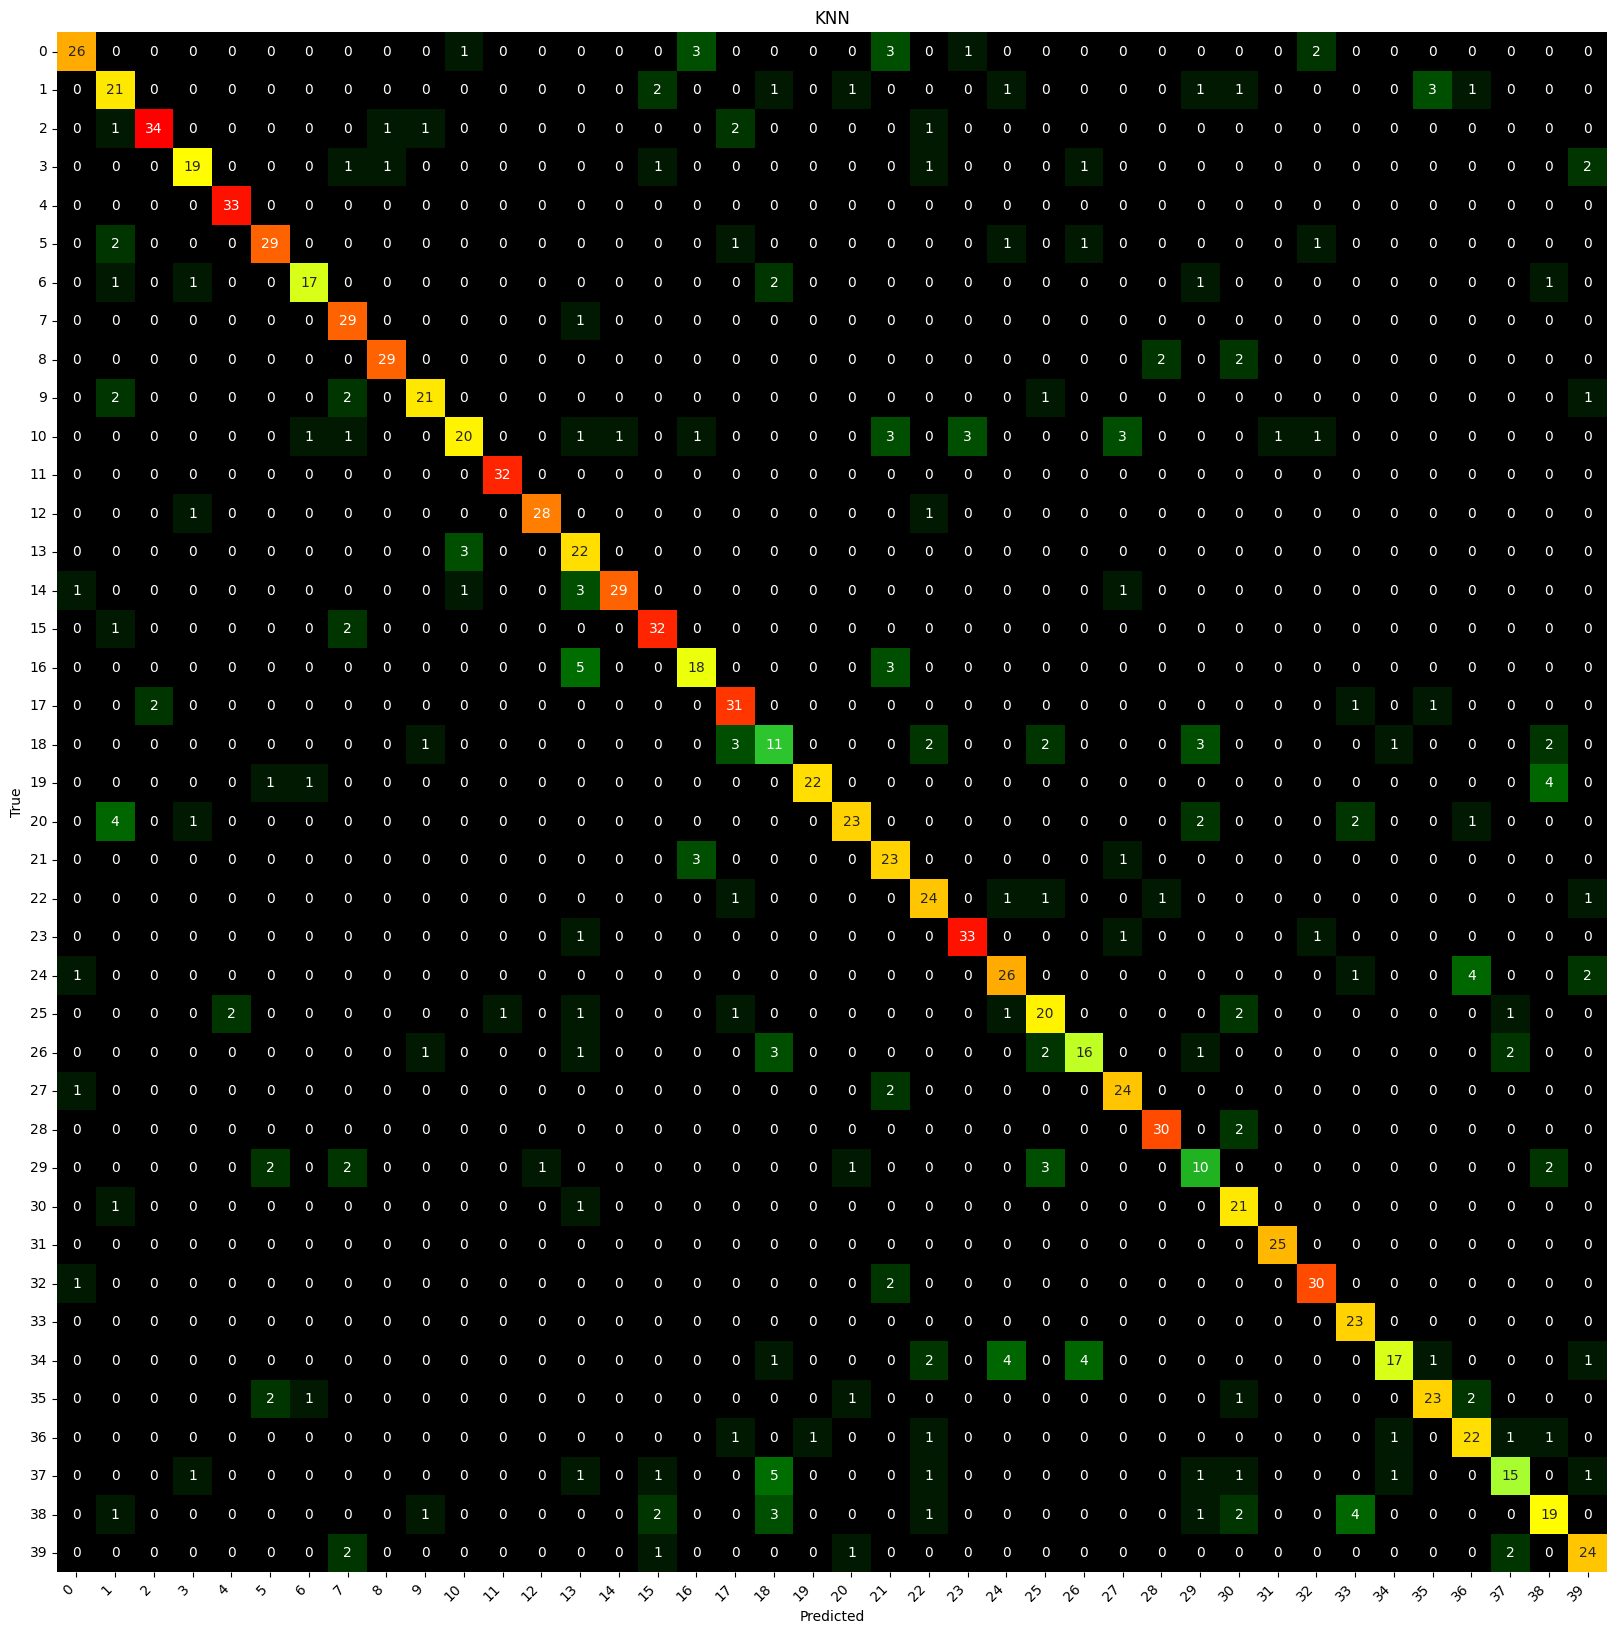

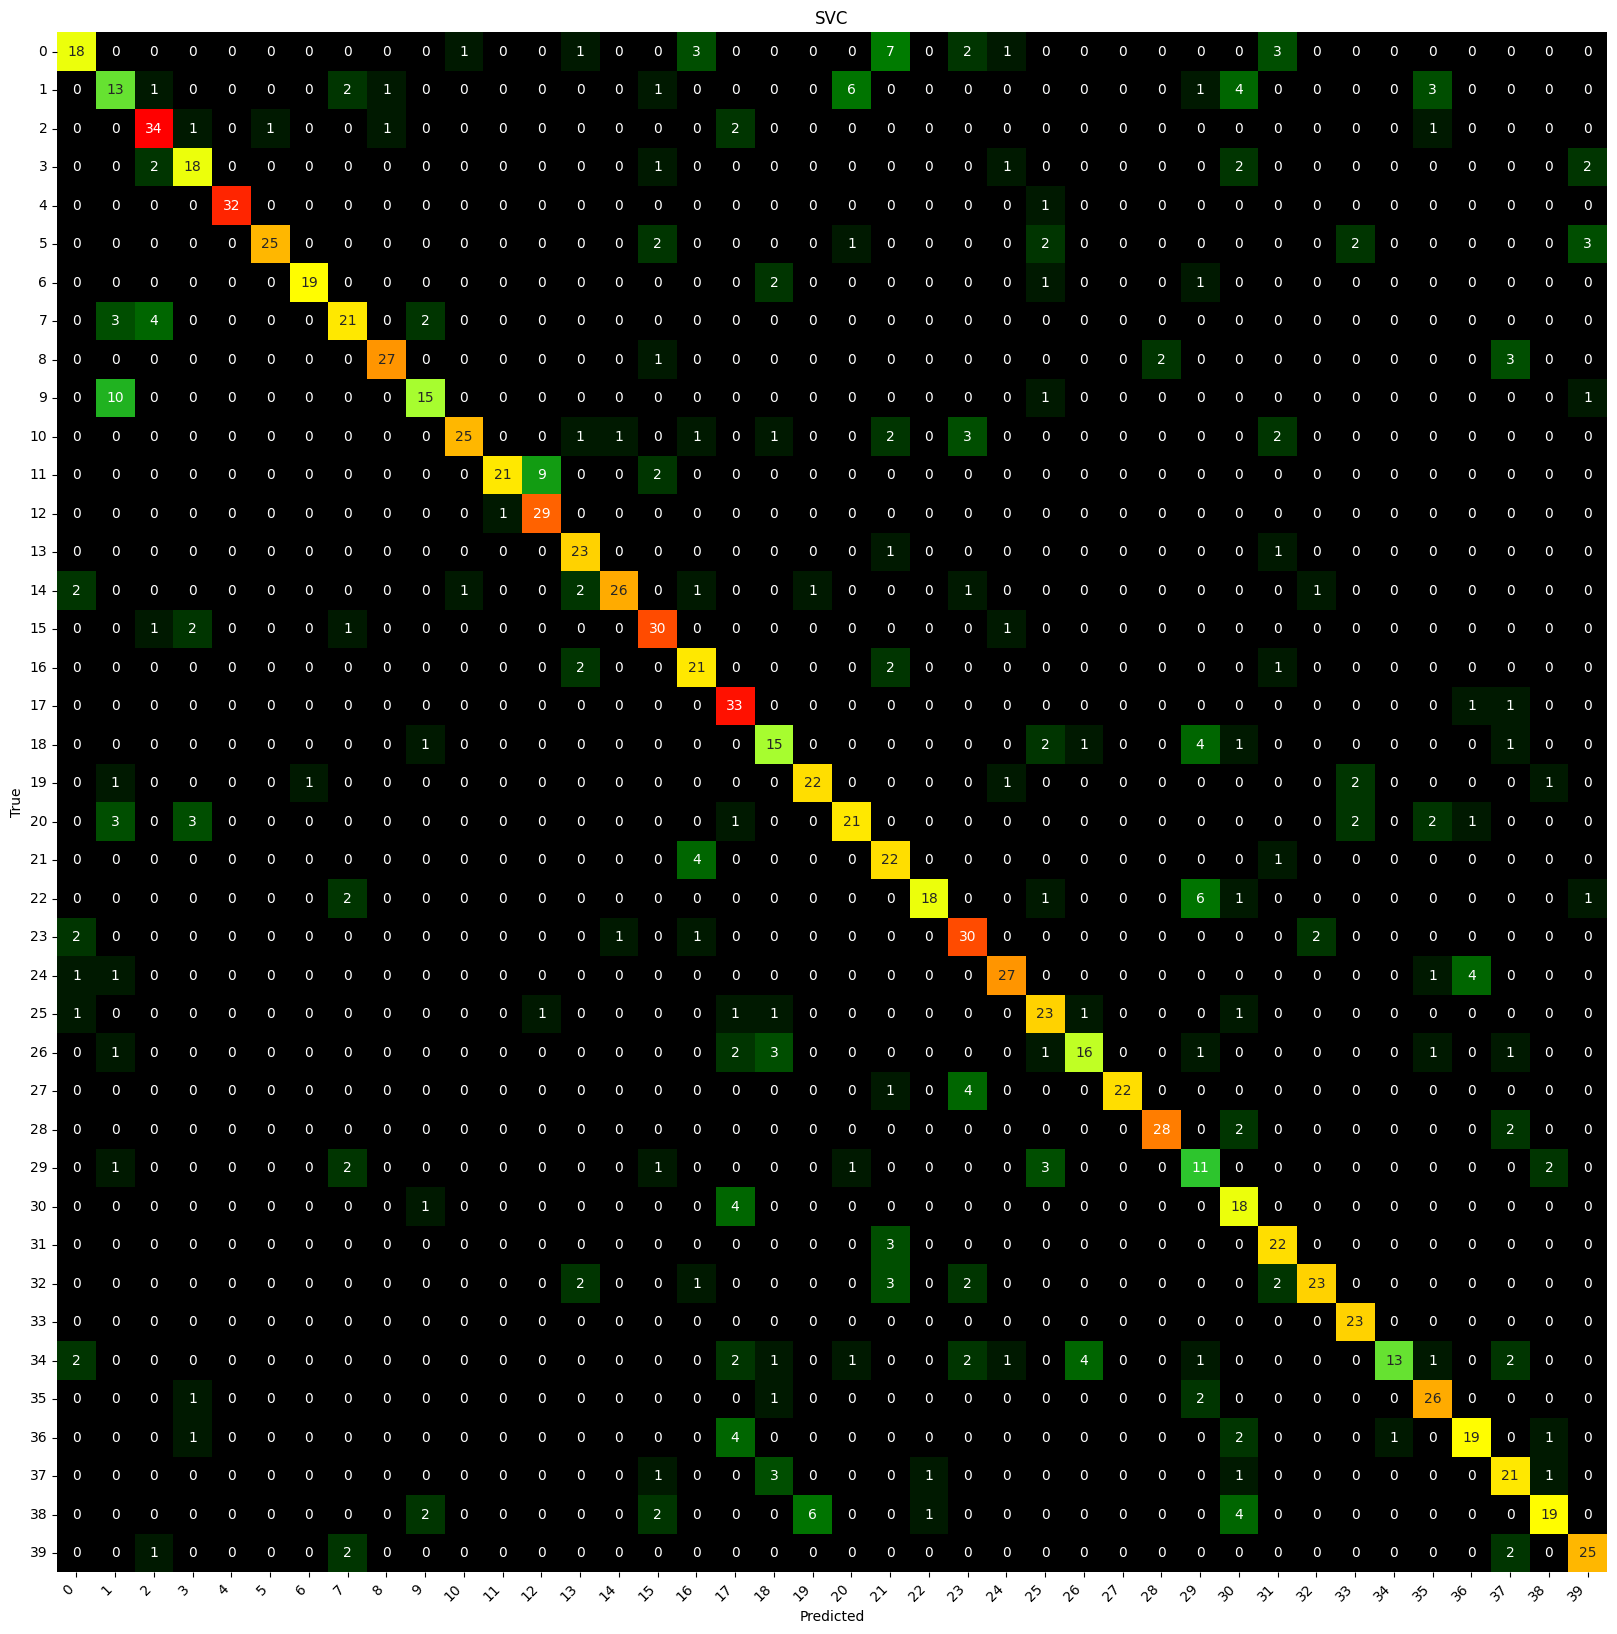

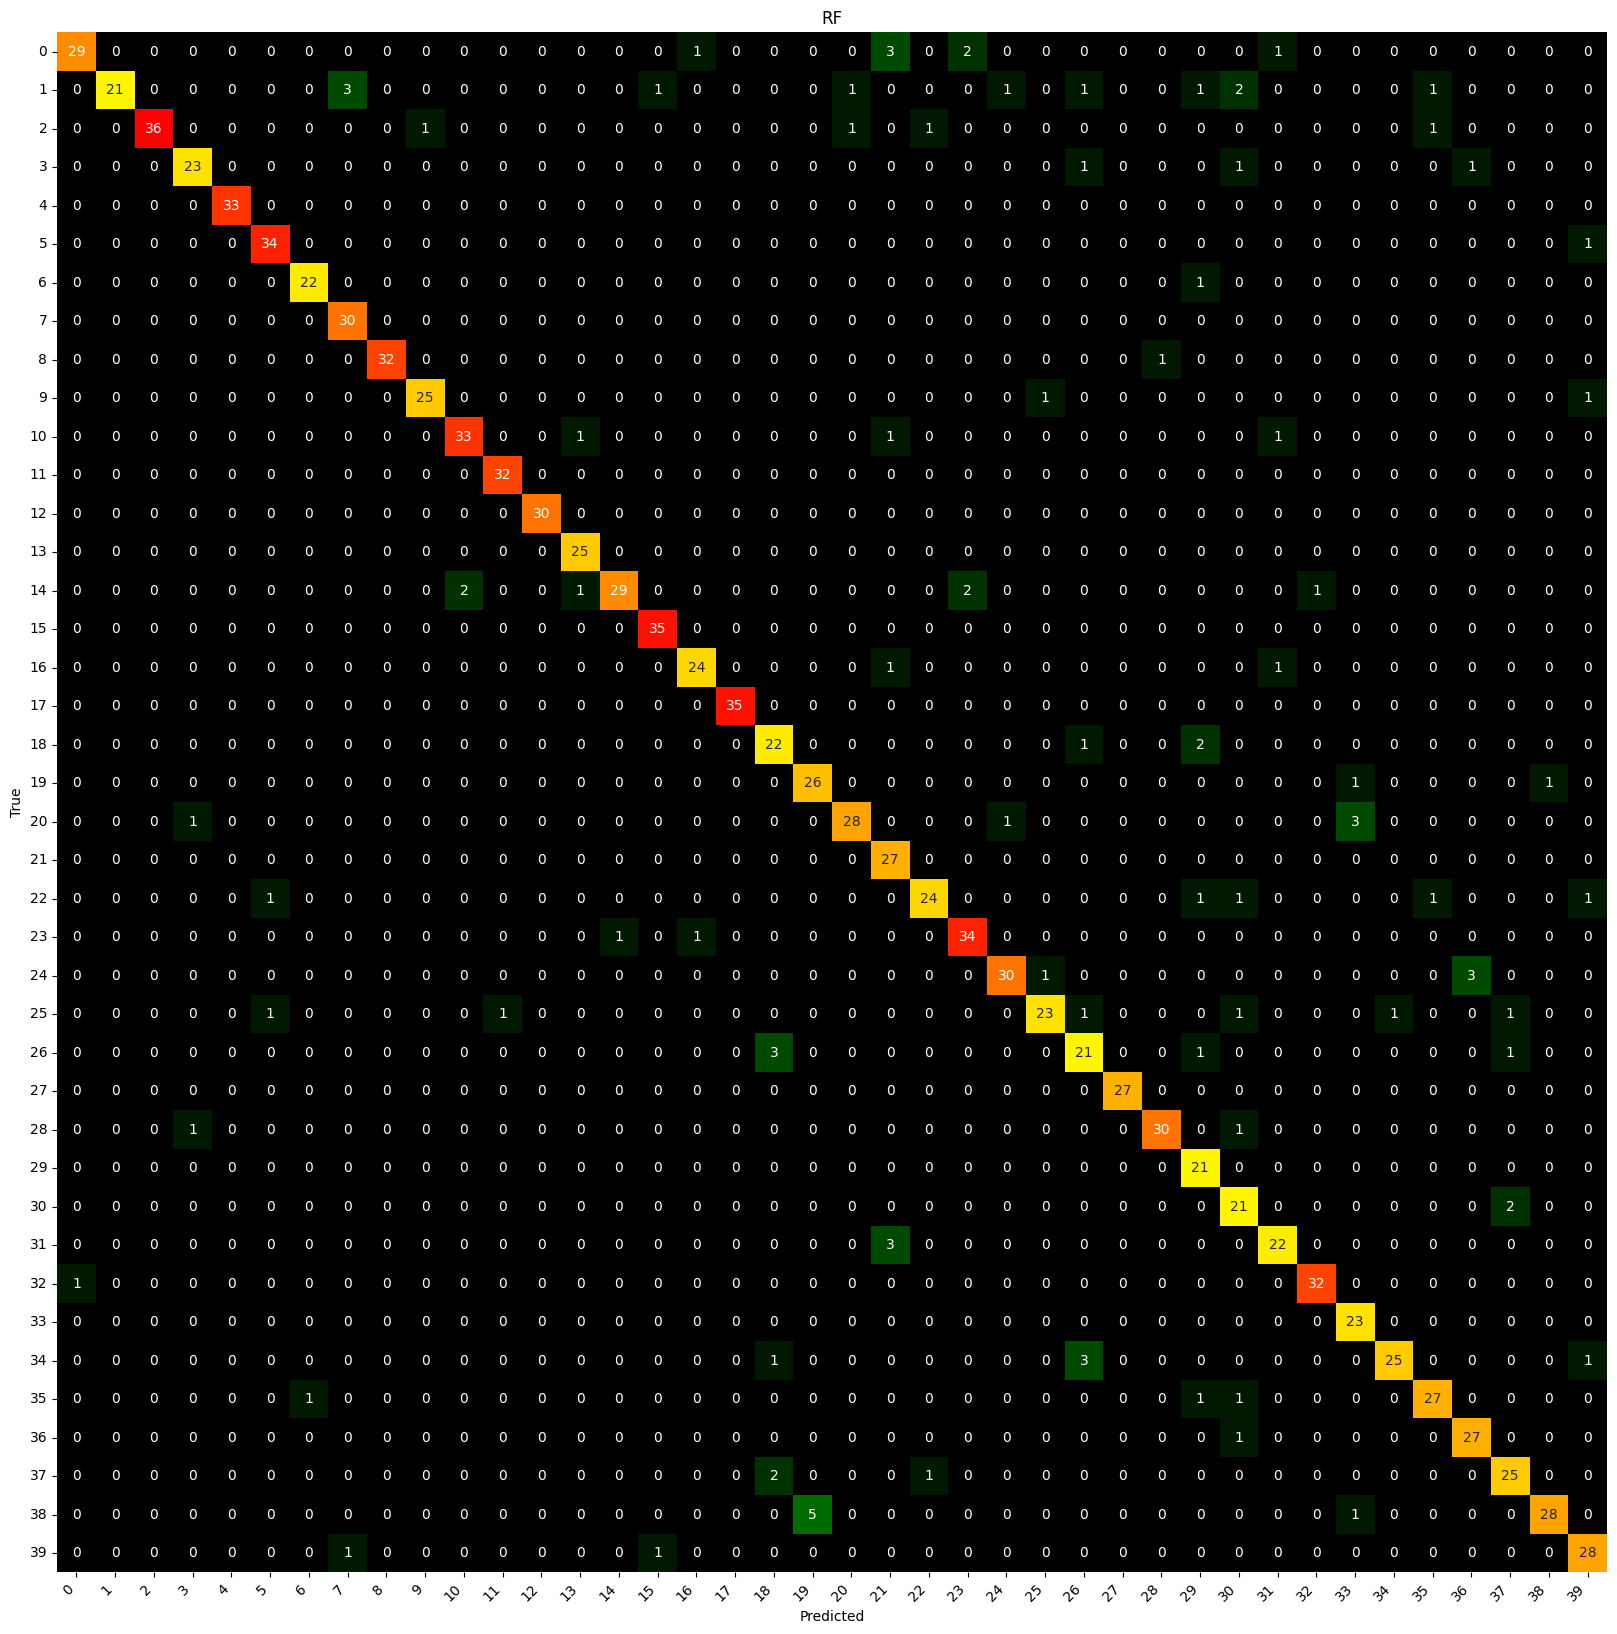

In [15]:
header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62

top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_knn = f"{' |KNN':<10}  │ {akurasiknn:<10.8f} │ {presisiknn:<10.8f} │ {recalknn:<10.8f} │ {f1knn:<10.8f} |"
row_svc = f"{' |SVC':<10}  │ {akurasisvc:<10.8f} │ {presisisvc:<10.8f} │ {recalsvc:<10.8f} │ {f1svc:<10.8f} |"
row_rf = f"{' |RF':<10}  │ {akurasirf:<10.8f} │ {presisirf:<10.8f} │ {recalrf:<10.8f} │ {f1rf:<10.8f} |"

print(top_border)
print(header)
print(mid_border)
print(row_knn)
print(mid_border)
print(row_svc)
print(mid_border)
print(row_rf)
print(bottom_border)

colorsHeat = ['#FF0000', '#FF4500', '#FFA500', '#FFD700', '#FFFF00', '#ADFF2F', '#32CD32', '#008000', '#006400', '#000000']
# reverse the colors to make it more intuitive
colorsHeat = colorsHeat[::-1]
cmap = LinearSegmentedColormap.from_list("color", colorsHeat, N=256)


plt.figure(figsize=(20, 20), facecolor='None')
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_knn), fmt='d', cbar=False)
plt.title('KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(20, 20), facecolor='None')
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_svc), fmt='d', cbar=False)
plt.title('SVC')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(20, 20), facecolor='None')
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_rf), fmt='d', cbar=False)
plt.title('RF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


Kode tersebut berfungsi untuk mencetak hasil evaluasi model KNN, SVM, dan Random Forest dalam bentuk tabel yang rapi dan untuk menampilkan heatmap dari confusion matrix masing-masing model.

Pertama, kode membuat string format untuk header tabel, pemisah antar baris, dan batas atas, tengah, dan bawah tabel. Ini diatur dengan menggunakan string formatting untuk membuat tampilan tabel yang rapi. Header berisi kolom "Accuracy", "Precision", "Recall", dan "F1 Score", sementara pemisah dan batas digunakan untuk mengatur tampilan visual tabel.

Selanjutnya, kode mencetak hasil evaluasi untuk setiap model dalam tabel. Hasil evaluasi untuk model KNN disimpan dalam `row_knn`, untuk SVM disimpan dalam `row_svc`, dan untuk Random Forest disimpan dalam `row_rf`. Masing-masing baris ini diformat untuk menampilkan nilai akurasi, presisi, recall, dan skor F1 hingga delapan desimal.

Kemudian, tabel hasil evaluasi dicetak dengan memanggil `print()` untuk setiap bagian tabel, yaitu batas atas, header, pemisah, baris KNN, pemisah, baris SVC, pemisah, baris RF, dan batas bawah.

Setelah mencetak tabel, kode membuat heatmap dari confusion matrix untuk masing-masing model menggunakan `seaborn.heatmap`. Pertama, skema warna (`colorsHeat`) dibuat dan dibalik untuk membuatnya lebih intuitif, lalu digunakan untuk membuat colormap (`cmap`). Setiap heatmap ditampilkan dengan ukuran gambar yang besar (20x20), tanpa latar belakang (`facecolor='None'`), dan label sumbu yang dirotasi agar lebih mudah dibaca.

Heatmap pertama dibuat untuk model KNN dengan menggunakan `confusion_matrix(y_test, y_pred_knn)` untuk mendapatkan confusion matrix, dan `sns.heatmap()` untuk menampilkannya dengan colormap yang telah dibuat. Heatmap ini diberi judul "KNN" dan label sumbu "Predicted" dan "True".

Proses yang sama dilakukan untuk model SVM dan Random Forest, dengan heatmap masing-masing diberi judul "SVC" dan "RF".

Dengan demikian, kode ini tidak hanya mencetak hasil evaluasi model dalam bentuk tabel yang rapi, tetapi juga memberikan visualisasi performa model melalui heatmap confusion matrix, yang memudahkan analisis kinerja model.